In [41]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import cv2 as cv
import pprint
import csv
from PIL import Image

In [3]:
path = r"C:\Users\M305747\OneDrive - Mayo Clinic\MPC\medical-physics\Dr Zhou Projects\Automated Coil QC\GE\organized-imgs\coil sag-1.2.840.113619.2.453.5554020.7724153.26402.1700005970.639\coil sag-IM00024"
path2 = r"C:\Users\M305747\OneDrive - Mayo Clinic\MPC\medical-physics\Dr Zhou Projects\Automated Coil QC\GE\organized-imgs\coil sag-1.2.840.113619.2.453.5554020.7724153.26402.1700005970.634\coil sag-IM00023"

In [4]:
img1 = pydicom.dcmread(path)
elements1 = [x for x in img1.iterall() if x.tag.json_key != "7FE00010"]
img2 = pydicom.dcmread(path2)
elements2 = [x for x in img2.iterall() if x.tag.json_key != "7FE00010"]
differences = [idx for idx, x in enumerate(elements1) if elements1[idx] != elements2[idx]]

# unique1 = [elements1[idx] for idx in differences]
# unique2 = [elements2[idx] for idx in differences]
# results = [[f"{elements1[idx].tag.json_key}",f"{elements1[idx].description()}",f"{elements1[idx].value}",f"{elements2[idx].value}"] for idx in differences]

# savepth = r"C:\Users\M305747\Desktop\Test"
# newfile1 = os.path.join(savepth,"newfile1.csv")
# with open(newfile1, "w") as csvfile:
#     writer = csv.writer(csvfile)
#     for  item in results:
#         writer.writerow(item)
# csvfile.close()


In [46]:
pixels = img1.pixel_array
im = Image.fromarray(pixels)
jpgpath = r"C:\Users\M305747\test1.jpg"
im = im.convert("RGB")
im.save(jpgpath)
jpg = cv.imread(jpgpath)
jpgcolor = cv.cvtColor(jpg,cv.COLOR_GRAY2RGB)
scaled = np.uint8(np.maximum(pixels, 0) / pixels.max() * 255)
pixcopy = pixels.copy()

#initial thresholding of image
ret,thresh = cv.threshold(scaled,scaled.max()*0.10,scaled.max(),cv.THRESH_BINARY)
ret2,thresh2 = cv.threshold(scaled,scaled.max()*0.08,scaled.max(), cv.THRESH_BINARY)

canny = cv.Canny(np.uint8(thresh),100,255)
# plt.imshow(canny,cmap="gray")
# plt.show()
cnts, _ = cv.findContours(canny,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
cntslist = list(cnts)

newmask = np.zeros(pixcopy.shape,np.uint8)
erode = np.zeros(pixcopy.shape,np.uint8)
dilate = np.zeros(pixcopy.shape,np.uint8)
cv.drawContours(newmask,cntslist,0,1,-1)
# plt.imshow(newmask, cmap="gray")
# plt.show()
kernel = cv.getStructuringElement(shape=cv.MORPH_ELLIPSE,ksize=(7,7))
cv.erode(src=newmask,dst=erode,kernel=kernel, iterations=1)
cv.dilate(src=newmask,dst=dilate,kernel=kernel)
diff = dilate - erode
canny_diff = cv.Canny(diff,0,1)
# plt.figure(figsize=(8,8))
# plt.imshow(canny_diff)
edges,_ = cv.findContours(canny_diff,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
inmask = np.zeros(pixcopy.shape,np.uint8)
outmask = np.zeros(pixcopy.shape,np.uint8)

cv.drawContours(inmask,edges,3,1,-1)
cv.drawContours(outmask,edges,0,1,-1)
outmask = 1 - outmask

inmasked = cv.bitwise_and(pixcopy,pixcopy,mask=inmask)
outmasked = cv.bitwise_and(pixcopy,pixcopy,mask=outmask)
cvimage = cv.imread(path)


error: OpenCV(4.8.1) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<1,-1,-1>,struct cv::impl::A0xd8611878::Set<3,4,-1>,struct cv::impl::A0xd8611878::Set<0,2,5>,3>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 3


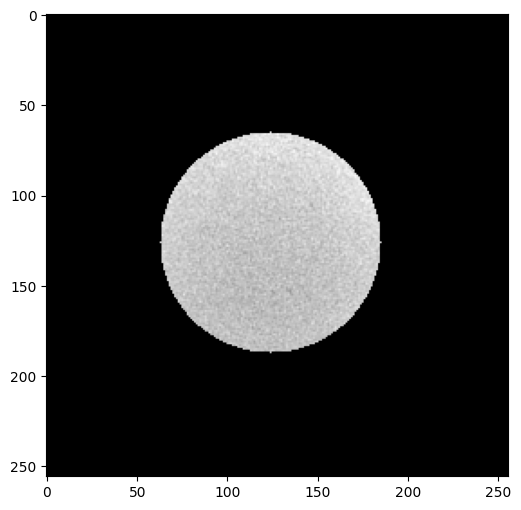

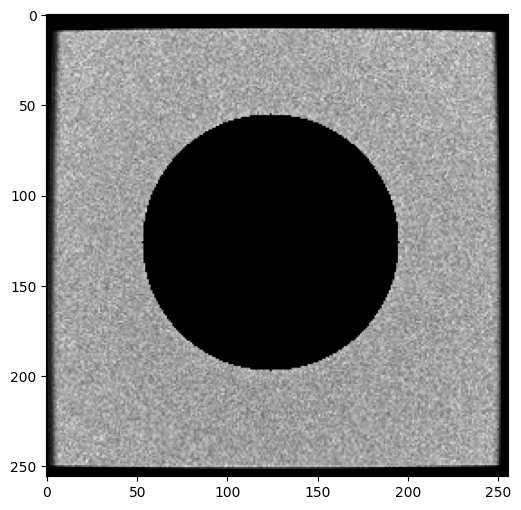

In [22]:
newcopy = pixels.copy()
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    peri = cv.arcLength(c, True)
    approx = cv.approxPolyDP(c, 0.04 * peri, True)
    area = cv.contourArea(c)
    if len(approx) > 5 and area > 1000 and area < 500000:
        ((x, y), r) = cv.minEnclosingCircle(c)
        cv.circle(newcopy, (int(x), int(y)), int(r) - 5, (255), 1)
        cv.circle(newcopy, (int(x), int(y)), int(r) + 5, (255), 1)
        innermask = np.uint8(np.zeros(pixels.shape))
        cv.circle(innermask, (int(x), int(y)), int(r) - 5, (255), -1)
        innermasked = cv.bitwise_and(pixels,pixels,mask=innermask)
        outermask = np.uint8(np.ones(pixels.shape))
        cv.circle(outermask, (int(x), int(y)), int(r) + 5, (0), -1)
        outermasked = cv.bitwise_and(pixels,pixels,mask=outermask)


plt.figure(figsize=(6,6))
plt.imshow(innermasked,cmap="gray")
plt.figure(figsize=(6,6))
plt.imshow(outermasked,cmap="gray")

In [226]:
outernonzero = outermasked.ravel()[np.flatnonzero(outermasked)]
noise_mean = outernonzero.mean()
noise_std = outernonzero.std()
innernonzero = innermasked.ravel()[np.flatnonzero(innermasked)]
phantom_mean = innernonzero.mean()
phantom_std = innernonzero.std()
snr = innernonzero.mean() / outernonzero.std()
print("Phantom Mean:",round(phantom_mean,2))
print("Noise Std:",round(noise_std,2))
print("SNR:",round(snr,2))

NameError: name 'outermasked' is not defined